<a href="https://colab.research.google.com/github/Joseperezpar/LSTM_project_2025/blob/main/LSTM_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for hydrological forecasting
## Part 1


In this notebook we will explore the different datasets, we will map the events of rain for the temperature and discharge data, and train basic models to have a baseline.

We will use a linear regression on the data as well as a random forest to see if simple models are enough for this forecasting , together with a persistence analysis. After that we will have a baseline for more complex ML models such as LSTM, passing by a intermediate XGboost model.

Steps in this notebook:
1. Import libraries
2. Import and clean data
3. Mapping of events
4. Training and evaluation of simple models:
  *   Linear regression
  *   Linear regression with random split of data
  *   Random Forest with Gridsearch (on the randomly splitted data)
  *   Linear regression with normalize data and with temporal splitting

5. Training and evaluation of intermediate model (XGBoost)
*   On the raw data
*   On normalized data and with hyperparameter search.

6. Persistence test









### Datasets


- Crissier precipitation data (mm/day) every 5 min (data log 5 min after measuring) from the 1992-11-30T00:05:00+01:00 to 2021-12-29T16:55:00+01:00.
- WSL lausannne air temperature (C) mean every 10 min from the 1996-12-10T13:00:00Z to 2025-08-12T16:30:00Z.
- Mèbre aval discharge data (m3/s) every 5 min (data log 5 min after measuring) from the 1992-12-31 23:05:00+00:00 to 2021-01-01 23:00:00+00:00.

- Chamberonne discharge data (m3/s) every 5 min (data log 5 min after measuring) from the 1993-01-01 00:30:00+00:00 to 2021-01-01 23:00:00+00:00.

## Importing libraries and setting up the notebook

In [ ]:
# COPY from LSTM notebook

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import the LinearRegression model
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler


from sklearn.metrics import r2_score, mean_squared_error

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

In [ ]:
# Import data
# Import the data into a Pandas DataFrame
from google.colab import drive
drive.mount('/content/drive/')
# Listar carpetas en "MyDrive"
mydrive_path = "/content/drive/MyDrive/LSTM_project/crissier_P.csv"

Mounted at /content/drive/


## Importing Data

In [ ]:
# Importing precipitation data

dP = pd.read_csv(mydrive_path,delimiter=";",skiprows = 1)
# datetime
dP["date"] = pd.to_datetime(dP["ISO Date"], utc=True, format="ISO8601", errors="coerce")
# reeplace NAN for 0 (as it means there were no measurements)

dP["Pluviometrie [mm/jour]"] = pd.to_numeric(
    dP["Pluviometrie [mm/jour]"], errors="coerce"
).dropna()

/tmp/ipython-input-1481786207.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dP = pd.read_csv(mydrive_path,delimiter=";",skiprows = 1)


In [ ]:
# We take very two time steps (to match the time resolution of 10 min)
dP2 = dP[1::2]
# We get rid of the missing values
dPn = dP2.dropna()
dPn

,ISO Date,Excel Date,Unix Date,Pluviometrie [mm/jour],date
9215,1993-01-01T00:00:00+01:00,33970.0,725842800,0.000,1992-12-31 23:00:00+00:00
11567,1993-01-09T04:00:00+01:00,33978.166667,726548400,0.204,1993-01-09 03:00:00+00:00
11799,1993-01-09T23:20:00+01:00,33978.972222,726618000,0.204,1993-01-09 22:20:00+00:00
11951,1993-01-10T12:00:00+01:00,33979.5,726663600,0.000,1993-01-10 11:00:00+00:00
12201,1993-01-11T08:50:00+01:00,33980.368056,726738600,0.204,1993-01-11 07:50:00+00:00
...,...,...,...,...,...
3060457,2021-12-29T13:45:00+01:00,44559.572917,1640781900,0.204,2021-12-29 12:45:00+00:00
3060483,2021-12-29T15:55:00+01:00,44559.663194,1640789700,0.204,2021-12-29 14:55:00+00:00
3060489,2021-12-29T16:25:00+01:00,44559.684028,1640791500,0.204,2021-12-29 15:25:00+00:00
3060491,2021-12-29T16:35:00+01:00,44559.690972,1640792100,0.204,2021-12-29 15:35:00+00:00


In [ ]:
# Importing temperature data
# Temperature
dT = pd.read_csv("/content/drive/MyDrive/LSTM_project/WSL_T.csv")
dT["date"] = pd.to_datetime(dT["messtime"], utc=True, format="ISO8601", errors="coerce")
dT.rename(columns={"messval": "temperature"}, inplace=True)
dT

,messvar_id,messtime,inserttime,temperature,date
0,2454,1996-12-10T13:00:00Z,1997-01-24T10:49:12Z,-3.22,1996-12-10 13:00:00+00:00
1,2454,1996-12-10T13:10:00Z,1997-01-24T10:49:12Z,-3.22,1996-12-10 13:10:00+00:00
2,2454,1996-12-10T13:20:00Z,1997-01-24T10:49:12Z,-3.20,1996-12-10 13:20:00+00:00
3,2454,1997-01-08T09:00:00Z,1997-01-24T10:49:12Z,-2.70,1997-01-08 09:00:00+00:00
4,2454,1997-01-21T12:50:00Z,1997-02-13T12:04:59Z,-3.48,1997-01-21 12:50:00+00:00
...,...,...,...,...,...
1452879,2454,2025-08-12T15:50:00Z,2025-08-12T15:55:46Z,33.22,2025-08-12 15:50:00+00:00
1452880,2454,2025-08-12T16:00:00Z,2025-08-12T16:06:32Z,33.33,2025-08-12 16:00:00+00:00
1452881,2454,2025-08-12T16:10:00Z,2025-08-12T16:15:46Z,33.42,2025-08-12 16:10:00+00:00
1452882,2454,2025-08-12T16:20:00Z,2025-08-12T16:25:46Z,33.55,2025-08-12 16:20:00+00:00


In [ ]:
# Importing discharge data
# Discharge
dD = pd.read_csv("/content/drive/MyDrive/LSTM_project/MAV_discharge.csv")
dD["date"] = pd.to_datetime(dD["ISO Date"], utc=True, format="ISO8601", errors="coerce")

# reeplace NAN for 0
dD["Debit [m3/s]"] = pd.to_numeric(
    dD["Debit [m3/s]"], errors="coerce"
).fillna(0)

In [ ]:
dD
# We take very two time steps (to match the timestamp and time resolution of 10 min)
dD2 = dD[1::2]
# We get rid of the missing values
dDn = dD2.dropna()
dDn

,ISO Date,Excel Date,Unix Date,Debit [m3/s],date
1,1992-12-31 23:10:00+00:00,33970.006944,725843400,0.000000,1992-12-31 23:10:00+00:00
3,1992-12-31 23:20:00+00:00,33970.013889,725844000,0.000000,1992-12-31 23:20:00+00:00
5,1992-12-31 23:30:00+00:00,33970.020833,725844600,0.000000,1992-12-31 23:30:00+00:00
7,1992-12-31 23:40:00+00:00,33970.027778,725845200,0.000000,1992-12-31 23:40:00+00:00
9,1992-12-31 23:50:00+00:00,33970.034722,725845800,0.000000,1992-12-31 23:50:00+00:00
...,...,...,...,...,...
2945655,2021-01-01 22:20:00+00:00,44197.972222,1609539600,0.579370,2021-01-01 22:20:00+00:00
2945657,2021-01-01 22:30:00+00:00,44197.979167,1609540200,0.579385,2021-01-01 22:30:00+00:00
2945659,2021-01-01 22:40:00+00:00,44197.986111,1609540800,0.579400,2021-01-01 22:40:00+00:00
2945661,2021-01-01 22:50:00+00:00,44197.993056,1609541400,0.000000,2021-01-01 22:50:00+00:00


In [ ]:
#@title Now we will do a exploratory analysis of the precipitation and index when there was rain (higher than the mean).
# Exploratory analysis of events
mean = dPn["Pluviometrie [mm/jour]"].mean()
mean

np.float64(0.26487268369192196)

In [ ]:
# mapping of events
# indexing events
events = dPn[(dPn["Pluviometrie [mm/jour]"]>=mean)]

In [ ]:
# Common dates to join
common_dates = set(dT["date"]).intersection(set(dD["date"])).intersection(set(events["date"]))

# mapping with dates (based on events)
dT = dT[dT["date"].isin(common_dates)]
dD = dD[dD["date"].isin(common_dates)]
events = events[events["date"].isin(common_dates)]

In [ ]:
#@title Lets check the new data
dT["date"]

,date
774,1997-03-24 02:50:00+00:00
1399,1997-03-28 11:00:00+00:00
6838,1997-05-05 07:30:00+00:00
6839,1997-05-05 07:40:00+00:00
6916,1997-05-05 20:30:00+00:00
...,...
1061614,2017-11-25 06:20:00+00:00
1061616,2017-11-25 06:40:00+00:00
1061628,2017-11-25 08:40:00+00:00
1061629,2017-11-25 08:50:00+00:00


## First models
### Linear Regression

In [ ]:
#@title We will start with the lineal regression
# Instantiate the model
lin_reg = LinearRegression()

In [ ]:
# transforming pandas dataframe to numpy array

# input data
temperature = dT['temperature'].values
precipitation = events["Pluviometrie [mm/jour]"].values

# prepare independant variables
X = np.column_stack((precipitation, temperature))

# prepare dependant variable
y = dD["Debit [m3/s]"].values

In [ ]:
# Fit the model
lin_reg.fit(X, y)

LinearRegression()

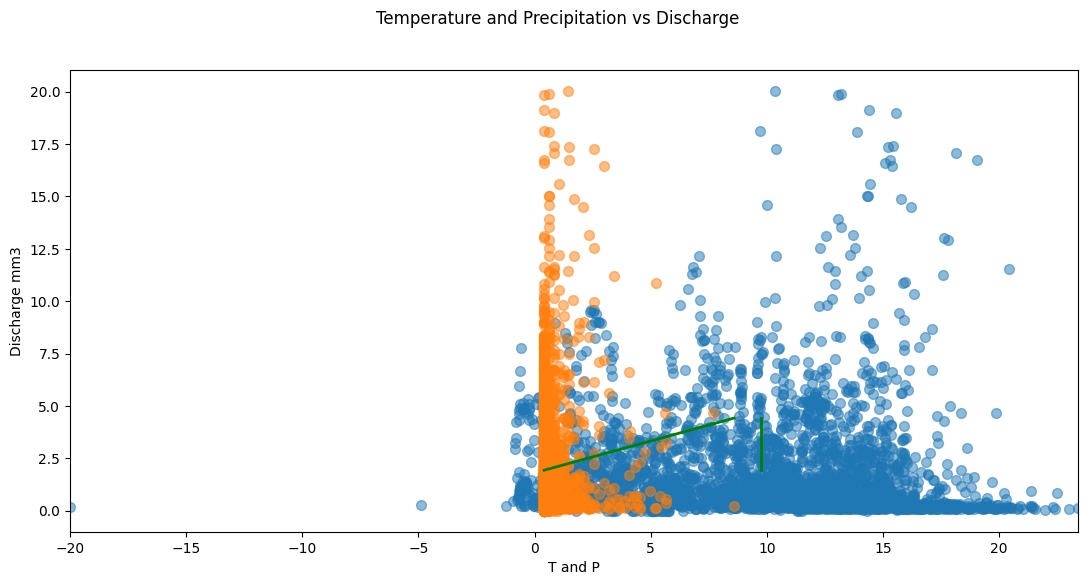

In [ ]:
# @title Just a quick glance of the data and of a regression
#Instantiate a figure having size 13,6
fig, ax = plt.subplots(figsize=(13,6))

"""----------------------------------------------------------------------------
Let's start by plotting the data points from our dataset
----------------------------------------------------------------------------"""
# Set figure title and axis labels
fig.suptitle('Temperature and Precipitation vs Discharge')
ax.set_xlabel("T and P")
ax.set_ylabel("Discharge mm3")

# The colors and styles suggested below are not compulsory, but please avoid
# using the default settings.
# Make a scatter plot for the pressure (x) and temperature (y). Use color=black,
# marker size = 100, and set the marker style to '2'.
ax.scatter(X[:,1], # Temperature
           y[:], # Discharge
           marker='o', # Marker style
           s=50, # Marker size
           label = "Temperature",
           alpha = 0.5)
ax.scatter(X[:,0], # Precipitation
           y[:], # Discharge
           marker='o', # Marker style
           s=50, # Marker size
           label = "Precipitation",
           alpha = 0.5)



'''----------------------------------------------------------------------------
Now, let's plot the line we fit to the datapoints
----------------------------------------------------------------------------'''
# Make a 100 point numpy array between  and store it in reg_x.
# Reshape it to (-1,1). Hint: numpy has a linear space generator
# the point are defined between the precipitation min and max
reg_x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100).reshape(-1, 1) # Reshape to row=sample, col=feature
# We leave fixed the temperature and stacked them
reg_X1 = np.column_stack((reg_x1, np.full_like(reg_x1, X[:, 1].mean())))

# Let's produce a set of predictions from our linear space array.
reg_y = lin_reg.predict(reg_X1)

# Let's plot the regression line using reg_x and reg_y. Set the color to red and
# the linewidth to 1.5
ax.plot(reg_X1, # X
        reg_y, # y
        color = "g", # Color
        linewidth=2) # Linewidth

ax.autoscale(axis='x', tight=True)

In [ ]:
#@title Now we want to compute the metrics to see if the model is adecuate for our problem.


X = np.column_stack((precipitation, temperature))
# Calculate the F-score and p-value for our dataset.


# Fetch the R2 value from the lin_reg model.
predicted_discharge = lin_reg.predict(X)
from sklearn.metrics import r2_score
R_squared = r2_score(y, # Ground truth
                    predicted_discharge) # Predictions
MSE = (mean_squared_error(y,predicted_discharge))
print(f'The R\u00b2 value is: {R_squared:.4f}',
      sep='\n')
print(f'The MSEvalue is: {MSE:.4f}',
      sep='\n')

The R² value is: 0.0071
The MSEvalue is: 6.0982


So definitely our model doesnt explain the variablity of our data. Only 1%.

Now we are going to split the data in training for all years except the last one, and the last one will be used for test.

In [ ]:
# Instantiate the model
lin_reg2 = LinearRegression()

In [ ]:
events['year'] = events['date'].dt.year
dT['year'] = dT['date'].dt.year
dD['year'] = dD['date'].dt.year
# list with years

years = events["year"].unique()
# take last year
last_year = years[-1]

# take the dataset except for last years data
events_training = events[events["year"]!= last_year]
dT_training = dT[dT["year"] != last_year]
dD_training = dD[dD["year"] != last_year]

# training the data
X_train = np.column_stack((events_training['Pluviometrie [mm/jour]'], dT_training['temperature']))
y_train = dD_training['Debit [m3/s]'].values

X_train2 , X_valid, y_train2 , y_valid = train_test_split(
X_train, y_train, test_size=0.25, random_state=rnd_seed)

# test dataset
events_test = events[events["year"] == last_year]
dT_test = dT[dT["year"] == last_year]
dD_test = dD[dD["year"] == last_year]

# processing X data test
X_test = np.column_stack((events_test['Pluviometrie [mm/jour]'], dT_test['temperature']))
y_test = dD_test['Debit [m3/s]'].values

/tmp/ipython-input-2514859381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dT['year'] = dT['date'].dt.year


In [ ]:
# Fitting the data
lin_reg2.fit(X_train2, y_train2)

LinearRegression()

In [ ]:
# Prediction
y_pred = lin_reg2.predict(X_test)

In [ ]:
# Evaluation the model

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")
mse = (mean_squared_error(y_test, y_pred))
print(f"MSE: {mse:.4f}")

R-squared: -0.0514
MSE: 6.5247


Definetely the linear model is not good enough. Then as we have already the data splitted, we will train a Random forest.

In [ ]:
#@title We will start by listing the parameters we want to tune for the gridsearch for the Random Forest.
param_grid = {"max_leaf_nodes":range(2,10), "min_samples_split":range(2,10)}

In [ ]:
# Lets do the search then!
gsc_tree = GridSearchCV(RandomForestRegressor(random_state=rnd_seed),param_grid,cv=2,verbose=1)
gsc_tree.fit(X_train2,y_train2)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [ ]:
# Check the best estimators
gsc_tree.best_estimator_

RandomForestRegressor(max_leaf_nodes=6, min_samples_split=9, random_state=42)

In [ ]:
# Make predictions on the training and test sets with your best model
y_pred_train = gsc_tree.predict(X_train2)
y_pred_test = gsc_tree.predict(X_test)

In [ ]:
# Evaluate the model
# Root Mean Squared Error (RMSE)
mse = (mean_squared_error(y_test, y_pred_test))
print(f"Mean Squared Error: {mse:.3f}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred_test)
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 6.668
R-squared: -0.0746


### But ... what about normalizing the data (make sense as the magnitudes could be different)? And try again!
More importantly to keep the temporal correlation, we should not split randomly the data! Let's take 50% of the first years for the train set, 25% for validation and 25% of the rest for the test set.

In [ ]:
# Splitting the data
events['year'] = events['date'].dt.year
dT['year'] = dT['date'].dt.year
dD['year'] = dD['date'].dt.year
# list with years

years = events["year"].unique()
# take last year
last_year = years[-1]

# take the dataset except for last years data
events_training = events[events["year"]!= last_year]
dT_training = dT[dT["year"] != last_year]
dD_training = dD[dD["year"] != last_year]

# training the data
X_train = np.column_stack((events_training['Pluviometrie [mm/jour]'], dT_training['temperature']))
y_train = dD_training['Debit [m3/s]'].values

# Time-based validation split (e.g., last 25% of training)
N_valid = int(0.25 * len(X_train))
X_train2, X_valid = X_train[:-N_valid], X_train[-N_valid:]
y_train2, y_valid = y_train[:-N_valid], y_train[-N_valid:]

# test dataset
events_test = events[events["year"] == last_year]
dT_test = dT[dT["year"] == last_year]
dD_test = dD[dD["year"] == last_year]

# processing X data test
X_test = np.column_stack((events_test['Pluviometrie [mm/jour]'], dT_test['temperature']))
y_test = dD_test['Debit [m3/s]'].values

/tmp/ipython-input-4206339512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dT['year'] = dT['date'].dt.year


In [ ]:
# Instantiate the model
lin_reg_r = LinearRegression()

In [ ]:
# Normalize x
scaler_X = StandardScaler()
X_train2_scaled = scaler_X.fit_transform(X_train2)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train2_scaled = scaler_y.fit_transform(y_train2.reshape(-1,1)).flatten()
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

In [ ]:
# training model with normalized data
lin_reg_r.fit(X_train2_scaled,y_train2_scaled)

LinearRegression()

In [ ]:
# Prediction normalized
y_pred_r = lin_reg_r.predict(X_test_scaled)

In [ ]:
# Evaluation the model

r2 = r2_score(y_test_scaled, y_pred_r)
print(f"R-squared: {r2:.4f}")
mse = (mean_squared_error(y_test_scaled, y_pred_r))
print(f"Mean Squared Error: {mse:.3f}")

R-squared: -0.0316
Mean Squared Error: 1.263


### XGBoost
We will take a look at this intermediate model, and benefit form the splitting that we did before.


In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Building the model
xgb_model = XGBRegressor(
    n_estimators=500,      #
    learning_rate=0.05,    #
    max_depth=5,           #
    subsample=0.8,         #
    colsample_bytree=0.8,  #
    random_state=rnd_seed,
    early_stopping_rounds=20,   #
)

# Setting up early stopping
xgb_model.fit(
    X_train2, y_train2,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

[0]	validation_0-rmse:3.05177
[1]	validation_0-rmse:3.05076
[2]	validation_0-rmse:3.04705
[3]	validation_0-rmse:3.04784
[4]	validation_0-rmse:3.04738
[5]	validation_0-rmse:3.04742
[6]	validation_0-rmse:3.04916
[7]	validation_0-rmse:3.05120
[8]	validation_0-rmse:3.04947
[9]	validation_0-rmse:3.04935
[10]	validation_0-rmse:3.04686
[11]	validation_0-rmse:3.04714
[12]	validation_0-rmse:3.04572
[13]	validation_0-rmse:3.04592
[14]	validation_0-rmse:3.04351
[15]	validation_0-rmse:3.04487
[16]	validation_0-rmse:3.04450
[17]	validation_0-rmse:3.04516
[18]	validation_0-rmse:3.04445
[19]	validation_0-rmse:3.04631
[20]	validation_0-rmse:3.04302
[21]	validation_0-rmse:3.04202
[22]	validation_0-rmse:3.04159
[23]	validation_0-rmse:3.04083
[24]	validation_0-rmse:3.04031
[25]	validation_0-rmse:3.04066
[26]	validation_0-rmse:3.04134
[27]	validation_0-rmse:3.04285
[28]	validation_0-rmse:3.04279
[29]	validation_0-rmse:3.04241
[30]	validation_0-rmse:3.04201
[31]	validation_0-rmse:3.04117
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### XGBoost normalized

In [ ]:
# Normalize x
scaler_X = StandardScaler()
X_train2_scaled = scaler_X.fit_transform(X_train2)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train2_scaled = scaler_y.fit_transform(y_train2.reshape(-1,1)).flatten()
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

In [ ]:
# Building the model
xgb_model = XGBRegressor(
    n_estimators=500,      #
    learning_rate=0.05,    #
    max_depth=5,           #
    subsample=0.8,         #
    colsample_bytree=0.8,  #
    random_state=rnd_seed,
    early_stopping_rounds=20,   #
)

# Early stopping
xgb_model.fit(
    X_train2_scaled, y_train2_scaled,
    eval_set=[(X_valid_scaled, y_valid_scaled)],
    verbose=True
)

[0]	validation_0-rmse:1.35546
[1]	validation_0-rmse:1.35498
[2]	validation_0-rmse:1.35335
[3]	validation_0-rmse:1.35370
[4]	validation_0-rmse:1.35350
[5]	validation_0-rmse:1.35352
[6]	validation_0-rmse:1.35430
[7]	validation_0-rmse:1.35521
[8]	validation_0-rmse:1.35441
[9]	validation_0-rmse:1.35425
[10]	validation_0-rmse:1.35324
[11]	validation_0-rmse:1.35337
[12]	validation_0-rmse:1.35274
[13]	validation_0-rmse:1.35283
[14]	validation_0-rmse:1.35172
[15]	validation_0-rmse:1.35233
[16]	validation_0-rmse:1.35216
[17]	validation_0-rmse:1.35246
[18]	validation_0-rmse:1.35223
[19]	validation_0-rmse:1.35306
[20]	validation_0-rmse:1.35174
[21]	validation_0-rmse:1.35113
[22]	validation_0-rmse:1.35120
[23]	validation_0-rmse:1.35075
[24]	validation_0-rmse:1.34984
[25]	validation_0-rmse:1.34997
[26]	validation_0-rmse:1.35027
[27]	validation_0-rmse:1.35099
[28]	validation_0-rmse:1.35101
[29]	validation_0-rmse:1.35084
[30]	validation_0-rmse:1.35065
[31]	validation_0-rmse:1.35063
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Validation of results - Normalized
y_pred_valid_scaled = xgb_model.predict(X_valid_scaled)
mse_valid = (mean_squared_error(y_valid_scaled, y_pred_valid_scaled))
r2_valid = r2_score(y_valid_scaled, y_pred_valid_scaled)

# Test
y_pred_test_scaled = xgb_model.predict(X_test_scaled)
mse_test = (mean_squared_error(y_test_scaled, y_pred_test_scaled))
r2_test = r2_score(y_test_scaled, y_pred_test_scaled)

print(f"Validation: MSE = {mse_valid:.2f}, R² = {r2_valid:.2f}")
print(f"Test:       MSE = {mse_test:.2f}, R² = {r2_test:.2f}")

Validation: MSE = 1.81, R² = -0.02
Test:       MSE = 1.30, R² = -0.07


In [ ]:
#@title Now let's search for the optimal set of parameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=rnd_seed
)
param_gridXG = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_gridXG,
    scoring="r2",
    cv=2,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train2_scaled, y_train2_scaled)

print("Best parameters:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)

Fitting 2 folds for each of 243 candidates, totalling 486 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best R²: -0.05930906715050743


In [ ]:
best_model = grid_search.best_estimator_
y_pred_valid = best_model.predict(X_valid_scaled)

In [ ]:
mse_valid = (mean_squared_error(y_valid_scaled, y_pred_valid))
r2_valid = r2_score(y_valid_scaled, y_pred_valid)

print(f"MSE on validation set = {mse_valid:.2f}, R² = {r2_valid:.2f}")

MSE on validation set = 1.82, R² = -0.02


## We already have some baselines but let's do a Test of persistence and the training mean.

In [ ]:
#@title Persistence
# "A basic forecasting model that predicts future values by assuming they will remain the same as those from the previous day at the same time"
y_pred_persistence = y_test[:-1]
y_true_persistence = y_test[1:]

mse_persistence = (mean_squared_error(y_true_persistence, y_pred_persistence))
r2_persistence = r2_score(y_true_persistence, y_pred_persistence)

print(f"Persistence -: MSE = {mse_persistence:.2f}, R² = {r2_persistence:.2f}")

Persistence -: MSE = 3.77, R² = 0.39


In [ ]:
#@title Training mean


# Mean of the training
y_mean = np.mean(y_train2)

# With a constant prediction for the test
y_pred_mean = np.full_like(y_test, y_mean)

# Evaluation
mse_mean = (mean_squared_error(y_test, y_pred_mean))
r2_mean = r2_score(y_test, y_pred_mean)

print(f"Historic Mean: MSE = {mse_mean:.2f}, R² = {r2_mean:.2f}")

Historic Mean: MSE = 6.46, R² = -0.04


##**Conclusion:**
We have now an idea of the metrics we aim to surpass, but also we see that the simpler models fail to explain the relationships between the precipitation and temperature to the discharge. Therefore, we need a model with higher complexity.
##**Next steps:**
In this case, an ideal and fairly used model for forecasting is the Long Short Term Memory (LSTM). So it is needed to separate the data in different events to feed to a model that has memory. This analysis will continue in another google colab notebook.